# Models training

## Import dependencies

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from functools import partial
import warnings
import os
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from sklearn.metrics import mean_absolute_error, mean_squared_error

warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 2000)
pd.set_option('display.float_format', '{:20,.2f}'.format)
pd.set_option('display.max_colwidth', None)

## Load data

### Load the historical generation and weather training data that was augmented using feature engineering in the previous notebook

In [3]:
GEN_DATA_PATH = os.path.join('..','..', 'data', '2_feature_engineered_data.parquet')
df = pd.read_parquet(GEN_DATA_PATH)
TARGET_COL = 'DC Gen. Power'
display(df.head(5))

,Temperature,Precipitation Total,Relative Humidity,Wind Speed,Wind Direction,Cloud Cover Total,Cloud Cover High,Cloud Cover Medium,Cloud Cover Low,CAPE,Sunshine Duration,Shortwave Radiation,Longwave Radiation,UV Radiation,Direct Shortwave Radiation,Diffuse Shortwave Radiation,Mean Sea Level Pressure,DC Gen. Power,Device Temp.,Voltage,day,season_0,season_1,season_2,season_3,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,DC Gen. Power 1 Hour Lag,DC Gen. Power 2 Hour Lag,DC Gen. Power 4 Hour Lag,DC Gen. Power 24 Hour Lag,DC Gen. Power 720 Hour Lag,DC Gen. Power 24 Hour Rolling Mean,DC Gen. Power 24 Hour Rolling Std,DC Gen. Power 24 Hour Rolling Max,DC Gen. Power 24 Hour Rolling EMA,Shortwave Radiation 24 Hour Rolling Mean,Shortwave Radiation 24 Hour Rolling Std,Shortwave Radiation 24 Hour Rolling Max,Shortwave Radiation 24 Hour Rolling EMA,Wind Speed 24 Hour Rolling Mean,Wind Speed 24 Hour Rolling Std,Wind Speed 24 Hour Rolling Max,Wind Speed 24 Hour Rolling EMA,Temperature 24 Hour Rolling Mean,Temperature 24 Hour Rolling Std,Temperature 24 Hour Rolling Max,Temperature 24 Hour Rolling EMA,Relative Humidity 24 Hour Rolling Mean,Relative Humidity 24 Hour Rolling Std,Relative Humidity 24 Hour Rolling Max,Relative Humidity 24 Hour Rolling EMA,DC Gen. Power 48 Hour Rolling Mean,DC Gen. Power 48 Hour Rolling Std,DC Gen. Power 48 Hour Rolling Max,DC Gen. Power 48 Hour Rolling EMA,Shortwave Radiation 48 Hour Rolling Mean,Shortwave Radiation 48 Hour Rolling Std,Shortwave Radiation 48 Hour Rolling Max,Shortwave Radiation 48 Hour Rolling EMA,Wind Speed 48 Hour Rolling Mean,Wind Speed 48 Hour Rolling Std,Wind Speed 48 Hour Rolling Max,Wind Speed 48 Hour Rolling EMA,Temperature 48 Hour Rolling Mean,Temperature 48 Hour Rolling Std,Temperature 48 Hour Rolling Max,Temperature 48 Hour Rolling EMA,Relative Humidity 48 Hour Rolling Mean,Relative Humidity 48 Hour Rolling Std,Relative Humidity 48 Hour Rolling Max,Relative Humidity 48 Hour Rolling EMA,DC Gen. Power 720 Hour Rolling Mean,DC Gen. Power 720 Hour Rolling Std,DC Gen. Power 720 Hour Rolling Max,DC Gen. Power 720 Hour Rolling EMA,Shortwave Radiation 720 Hour Rolling Mean,Shortwave Radiation 720 Hour Rolling Std,Shortwave Radiation 720 Hour Rolling Max,Shortwave Radiation 720 Hour Rolling EMA,Wind Speed 720 Hour Rolling Mean,Wind Speed 720 Hour Rolling Std,Wind Speed 720 Hour Rolling Max,Wind Speed 720 Hour Rolling EMA,Temperature 720 Hour Rolling Mean,Temperature 720 Hour Rolling Std,Temperature 720 Hour Rolling Max,Temperature 720 Hour Rolling EMA,Relative Humidity 720 Hour Rolling Mean,Relative Humidity 720 Hour Rolling Std,Relative Humidity 720 Hour Rolling Max,Relative Humidity 720 Hour Rolling EMA,Hours Since Last Rain,days_since_installation,Wind Chill,Solar Zenith Angle
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-10-31 00:00:00,16.00,0.00,88.00,17.00,129.00,4.00,0.00,0.00,4.00,0.00,0.00,0.00,306.00,0.00,0.00,0.00,"1,020.00",0.00,0.00,0.00,31,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.00,0.00,"6,744.30",0.00,0.00,"20,702.05","25,422.50","97,134.20","22,580.75",137.79,155.40,436.00,136.49,20.29,4.33,29.00,19.59,16.67,1.37,19.00,16.70,85.25,5.58,93.00,85.19,"28,375.58","39,447.88","132,528.90","26,008.70",195.50,253.31,868.00,165.52,18.98,3.57,29.00,18.38,16.54,1.25,19.00,17.06,85.90,5.80,95.00,85.23,"22,863.31","47,533.52","204,958.74","31,273.32",192.32,280.37,988.00,208.83,16.46,7.00,33.00,15.79,15.55,3.85,28.00,16.27,79.28,13.93,100.00,78.88,0,1764,15.16,-40.93
2019-

## Split data

The dataset is split into three subsets: training, validation, and testing. 

- The training set comprises 60% of the data, used to train the machine learning models and tune their parameters.
- The validation set, which constitutes 20% of the data, serves as an additional evaluation step during model training to assess performance and adjust hyperparameters.
- Finally, the testing set, also representing 20% of the data, remains untouched during model development and is solely used for final performance evaluation to gauge the model's generalization capability.


In [35]:
train, validate, test = np.split(df, [int(.6*len(df)), int(.8*len(df))])

x_train = train.drop(columns=[TARGET_COL])
x_val = validate.drop(columns=[TARGET_COL])
x_test = test.drop(columns=[TARGET_COL])

y_train = train[TARGET_COL]
y_val = validate[TARGET_COL]
y_test = test[TARGET_COL]

x_scaler = StandardScaler()
y_scaler = StandardScaler()

x_train_scaled = x_scaler.fit_transform(x_train)
x_val_scaled = x_scaler.transform(x_val)
x_test_scaled = x_scaler.transform(x_test)

y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_val_scaled = y_scaler.transform(y_val.values.reshape(-1, 1))
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1))

print('Train: ', len(train))
print('Validate: ', len(validate))
print('Test: ', len(test))

Train:  15152
Validate:  5051
Test:  5051


# Training

This section focuses on training machine learning models for power generation prediction. We will explore various algorithms, optimize their hyperparameters, and evaluate their performance to identify the best model for this task.

In [36]:
results = pd.DataFrame()
def calculate_metrics(y_pred, y_val, model_name, hyperparams):
    """
    Calculate metrics for the model
    """
    global results
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_val, y_pred)
    #print(f'Model: {model_name}')
    #print(f'Hyperparameters: {hyperparams}')
    # print(f'MSE: {mse}')
    # print(f'RMSE: {rmse}')
    #print(f'MAE: {mae}')
    #print('\n')
    

    df = pd.DataFrame({
        'model': [model_name],        
        'mae': [mae],
        'mse': [mse],
        'mae': [mae],
        'hyperparams': [hyperparams]
    })
    results = pd.concat([results, df])   

    return mse, rmse, mae

def plot_predictions(y_pred, y_val, n=200):
    plt.figure(figsize=(20, 8))
    plt.plot(y_val[-n:], label='Actual')
    plt.plot(y_pred[-n:], label='Predicted')
    plt.legend()
    plt.show()

def plot_feature_importance(model, x_val, y_val, n=20):
    r = permutation_importance(model, x_val, y_val, n_repeats=30, random_state=0)
    sorted_idx = r.importances_mean.argsort()[-n:]
    fig, ax = plt.subplots()
    ax.boxplot(r.importances[sorted_idx].T, vert=False, labels=x_val.columns[sorted_idx])
    ax.set_title("Feature importance")
    fig.tight_layout()
    plt.show()

## Hyperparameter tuning

Machine learning models rely on various parameters that influence their learning and prediction capabilities. These parameters are called hyperparameters, and their optimal settings can significantly impact model performance. Manually searching for the best hyperparameter combinations can be time-consuming and inefficient. Here, we leverage Hyperopt, a powerful hyperparameter optimization library, to automate this process. Hyperopt will explore the defined hyperparameter space for each model, efficiently identify promising configurations, and ultimately guide us towards the hyperparameter settings that optimize the model's performance for predicting power generation.

In [37]:
def objective(params, model_factory):
    global best_loss, best_model

    model = model_factory(**params)
    model.fit(x_train_scaled, y_train_scaled)
    y_pred = model.predict(x_val_scaled)
    y_pred = y_scaler.inverse_transform(y_pred.reshape(-1, 1)) 
    mae = mean_absolute_error(y_val, y_pred)
    model_name = model.__class__.__name__
    calculate_metrics(y_pred, y_val, model_name, params)
    
    if mae < best_loss:
        best_loss = mae
        best_model = model    

    return {'loss': mae, 'status': STATUS_OK}

def experiment(model_factory, space, max_evals=100):
    global best_loss, best_model, y_scaler
    best_loss = np.inf
    best_model = None

    trials = Trials()
    fmin(partial(objective, model_factory=model_factory), space, algo=tpe.suggest, max_evals=max_evals, trials=trials)
    # print best score    

    y_pred = best_model.predict(x_val_scaled)
    y_pred = y_scaler.inverse_transform(y_pred.reshape(-1, 1))
    plot_predictions(y_pred, y_val.values)
    print(f'Best loss: {best_loss}')
    return best_model

## Baseline Model: Last Observed Value

To establish a benchmark for evaluating the performance of more sophisticated models, we first introduce a simple baseline model. This naive model predicts the power generation for a given hour by assuming it will be the same value as the previous hour (last observed value). By comparing the performance of this baseline model with more complex models trained in subsequent sections, we can assess the effectiveness of those models in capturing the underlying trends and patterns within the data that influence power generation.

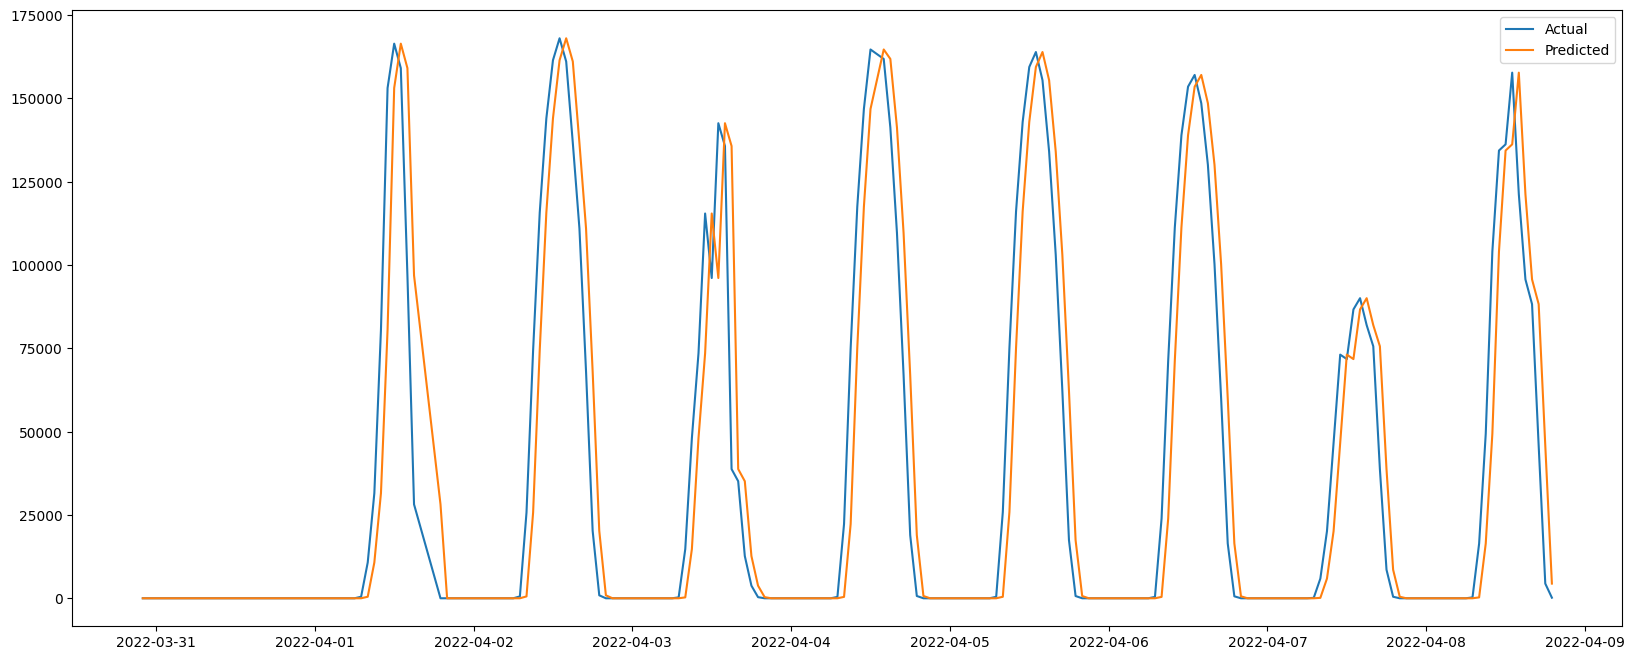

In [38]:
x_train = train.drop(columns=[TARGET_COL])
y_train = train[TARGET_COL]

y_pred = y_val.shift(1).fillna(method='bfill')

calculate_metrics(y_pred, y_val, 'Naive', {})
plot_predictions(y_pred, y_val)


## Linear models

Linear regression models form the foundation of many statistical and machine learning techniques. Their core strength lies in their simplicity, interpretability, and ability to capture linear relationships between variables. In the context of power generation prediction, this translates to effectively modeling how changes in independent variables, such as weather conditions or historical generation data, linearly influence the predicted power output.

### Linear regression

Linear regression, a core component of linear modeling, provides valuable insights into the relationship between independent variables and a continuous target variable. By assuming a linear relationship, linear models offer transparency in understanding how changes in predictors influence the outcome, making them accessible and interpretable for practitioners and stakeholders.

  0%|          | 0/2 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 2/2 [00:00<00:00,  4.17trial/s, best loss: 7929.632247301543]


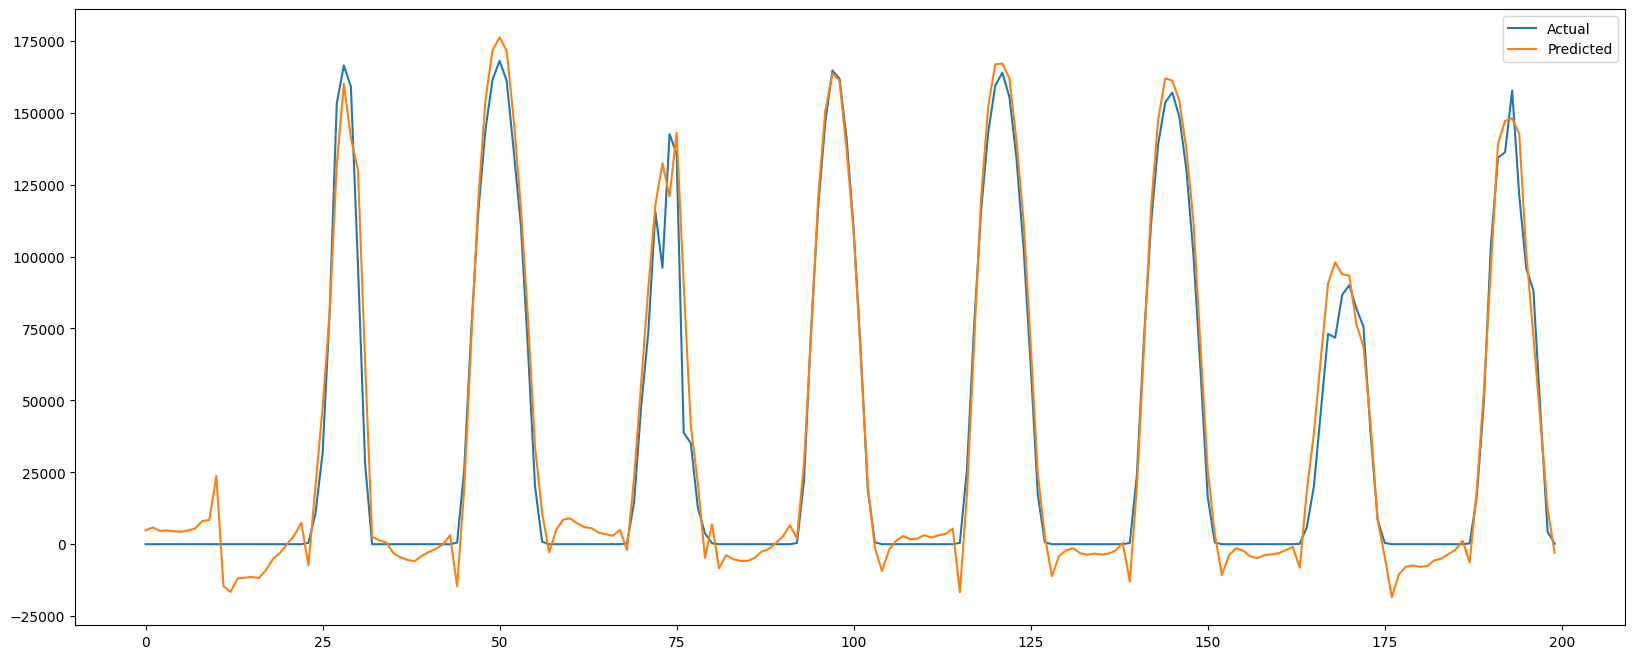

Best loss: 7929.632247301543


LinearRegression()

In [8]:
model_factory = lambda **params: LinearRegression(**params)

space = {
    'fit_intercept': hp.choice('fit_intercept', [True]),
}

experiment(model_factory, space, max_evals=2)

### Lasso

The Lasso Regression model, also known as L1 regularization, is a variant of linear regression that incorporates penalty terms to enforce sparsity in the coefficient estimates. By penalizing the absolute size of the coefficients, Lasso Regression encourages feature selection and promotes models with fewer predictors, making it particularly useful for high-dimensional datasets.

100%|██████████| 20/20 [01:11<00:00,  3.56s/trial, best loss: 7680.117077817709]


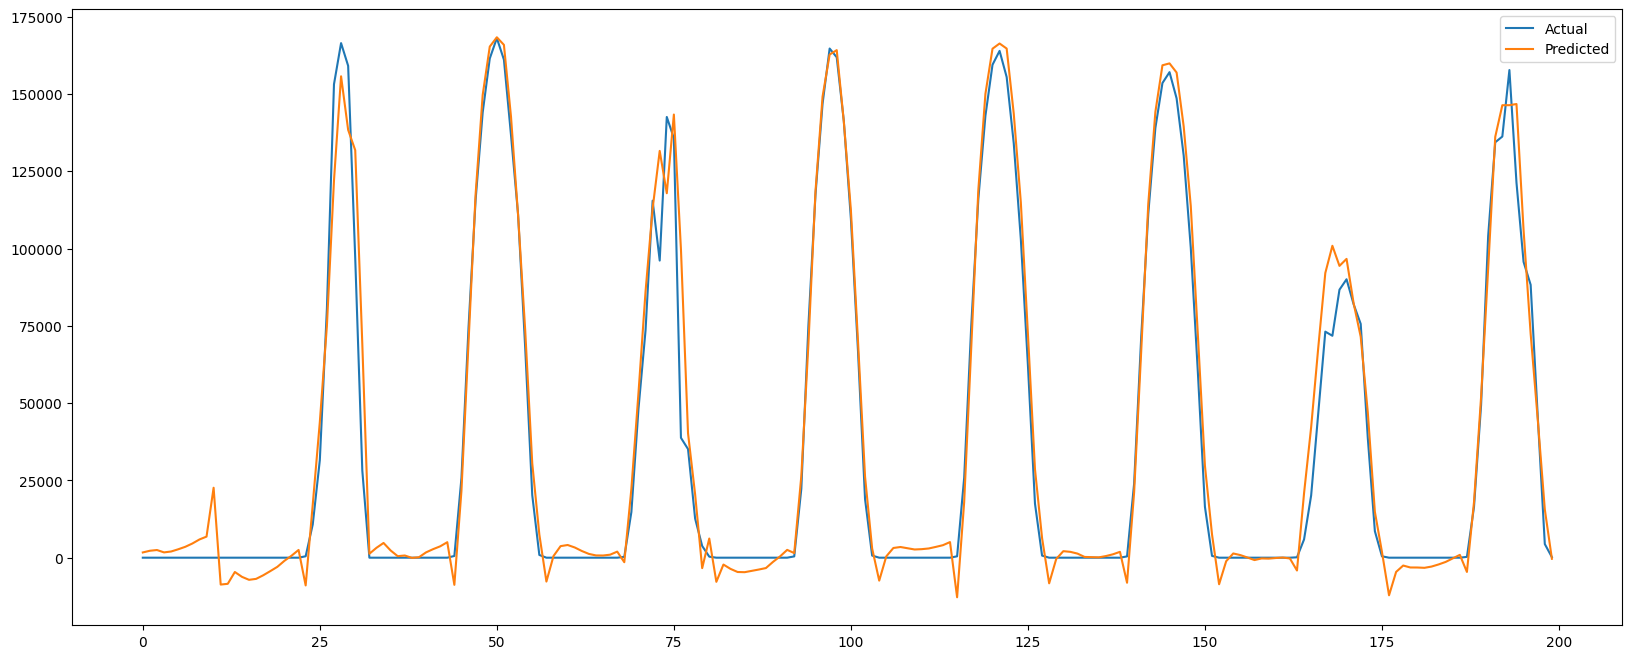

Best loss: 7680.117077817709


LassoCV(eps=0.0012354141969121632, n_alphas=400, n_jobs=-1,
        tol=0.0060685954125019636)

In [9]:
model_factory = lambda **params: LassoCV(**params, n_jobs=-1)
space = {
    'n_alphas': hp.choice('n_alphas', [10, 100, 200, 400]),
    'eps': hp.uniform('eps', 0.001, 0.1),
    'tol': hp.uniform('tol', 0.0001, 0.01),
}

experiment(model_factory, space, max_evals=20)

### Ridge

Ridge Regression, a variant of linear regression, introduces L2 regularization to penalize the sum of squared coefficients, effectively shrinking their magnitudes. By imposing a penalty on large coefficients, Ridge Regression mitigates multicollinearity and reduces model complexity, promoting better generalization performance.


100%|██████████| 2/2 [00:00<00:00,  2.09trial/s, best loss: 7901.131188162974]


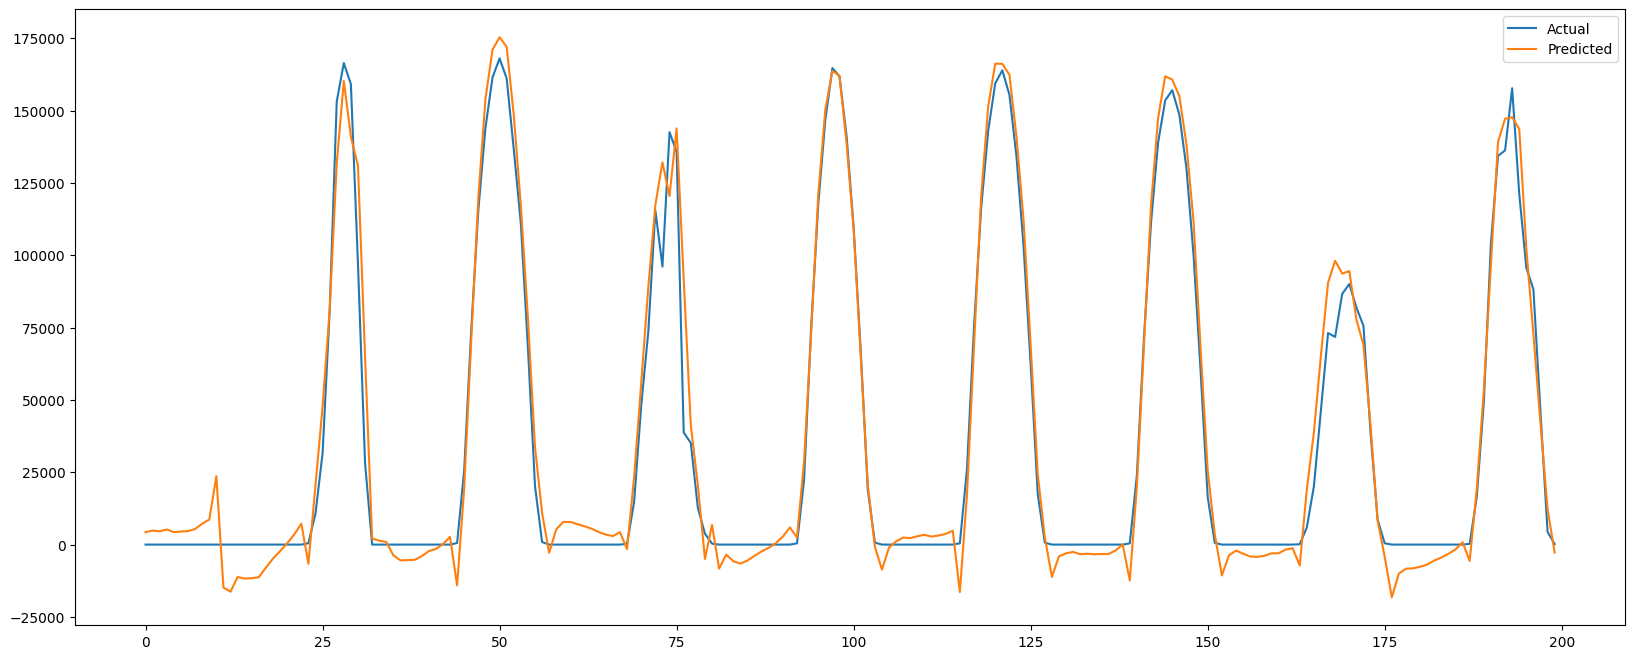

Best loss: 7901.131188162974


RidgeCV(alpha_per_target=True)

In [10]:
model_factory = lambda **params: RidgeCV(**params)
space = {
    'fit_intercept': hp.choice('fit_intercept', [True]),
    'alpha_per_target': hp.choice('alpha_per_target', [True]),
}

experiment(model_factory, space, max_evals=2)


### ElasticNet

ElasticNet Regression is a linear model that combines the regularization techniques of Ridge and Lasso regression. By incorporating both L1 (Lasso) and L2 (Ridge) penalties into its objective function, ElasticNet offers a balanced approach to feature selection and regularization. This hybrid model is particularly effective in scenarios with high-dimensional data and multicollinearity issues, providing a flexible framework for predictive modeling tasks. 


100%|██████████| 50/50 [00:17<00:00,  2.81trial/s, best loss: 8506.919087429993] 


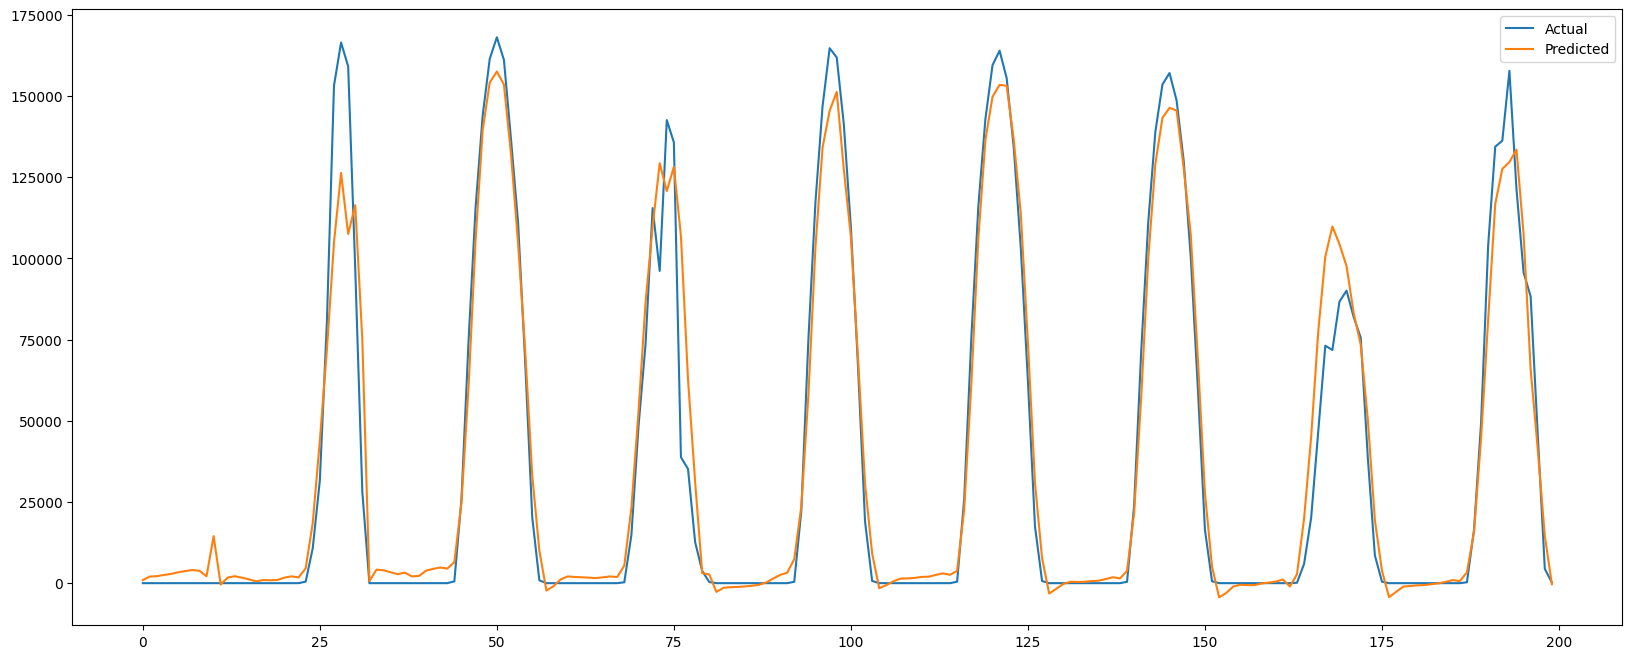

Best loss: 8506.919087429993


ElasticNet(alpha=0.11447001608996135, l1_ratio=0.10405106667367772,
           max_iter=100, tol=0.00627116052704416)

In [11]:
model_factory = lambda **params: ElasticNet(**params)
space = {
    'alpha': hp.uniform('alpha', 0.1, 1.0),
    'l1_ratio': hp.uniform('l1_ratio', 0.1, 1.0),
    'fit_intercept': hp.choice('fit_intercept', [True]),
    'tol': hp.uniform('tol', 0.0001, 0.01),
    'selection': hp.choice('selection', ['cyclic', 'random']),
    'max_iter': hp.choice('max_iter', [100, 2000, 4000]),
}

experiment(model_factory, space, max_evals=50)

## Decision trees

Following the exploration of linear models, we now investigate decision trees (DTs) and random forests (RFs) for power generation prediction. These algorithms handle non-linear relationships between features and the target variable more effectively than linear models. DTs recursively partition the data space based on feature values, building a tree-like structure for prediction. RFs combine predictions from an ensemble of DTs, enhancing model robustness and potentially improving accuracy.

Our goals in this section are:

Capture Non-Linearity: Leverage potential non-linear relationships in the data that linear models might have missed.
Boost Accuracy: Potentially improve power generation prediction accuracy compared to linear models.
Maintain Interpretability: While interpretability is lower than linear models, DTs still offer insights into feature influence on predictions. RF interpretability might be slightly lower due to averaging, but valuable insights can still be gleaned.
We will train and evaluate DT and RF models, comparing their performance to the previously explored linear models. This will assess if non-linear modeling techniques can improve power generation prediction accuracy.

### Decision tree regressors
Decision Tree Regressors (DTR) are non-parametric supervised learning models that excel at uncovering non-linear patterns within data. This characteristic makes them well-suited for scenarios where the underlying relationships between features (independent variables) and the target variable (power generation) might be more complex than what can be represented by a straight line.

100%|██████████| 200/200 [00:39<00:00,  5.02trial/s, best loss: 5910.325926994484]


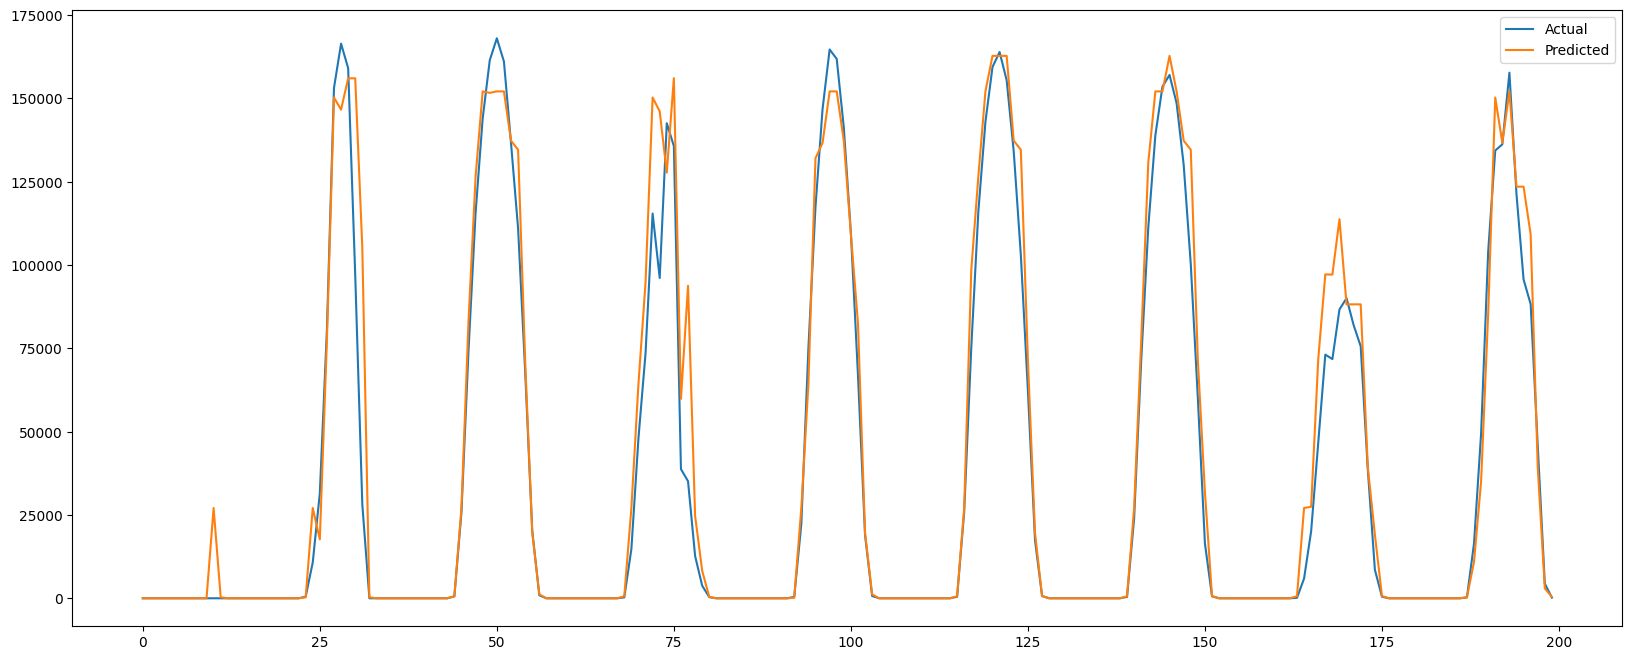

Best loss: 5910.325926994484


DecisionTreeRegressor(max_depth=16, max_features=64, min_samples_leaf=8,
                      min_samples_split=40)

In [12]:
model_factory = lambda **params: DecisionTreeRegressor(**params)

space = {
    'max_depth': hp.choice('max_depth', [None, 2, 4, 8, 16, 32, 64, 128]),
    'min_samples_split': hp.choice('min_samples_split', [2, 5, 10, 20, 40]),
    'min_samples_leaf': hp.choice('min_samples_leaf', [1, 2, 4, 8, 16]),
    'max_features': hp.choice('max_features', [8, 16, 32, 64]),
}

experiment(model_factory, space, max_evals=200)

### Random Forest Regressors
Random Forests (RFs) leverage ensemble learning, a technique that combines predictions from multiple decision tree regressors (DTRs) to achieve improved model robustness and potentially superior prediction accuracy.

100%|██████████| 20/20 [00:50<00:00,  2.54s/trial, best loss: 4976.03062925681] 


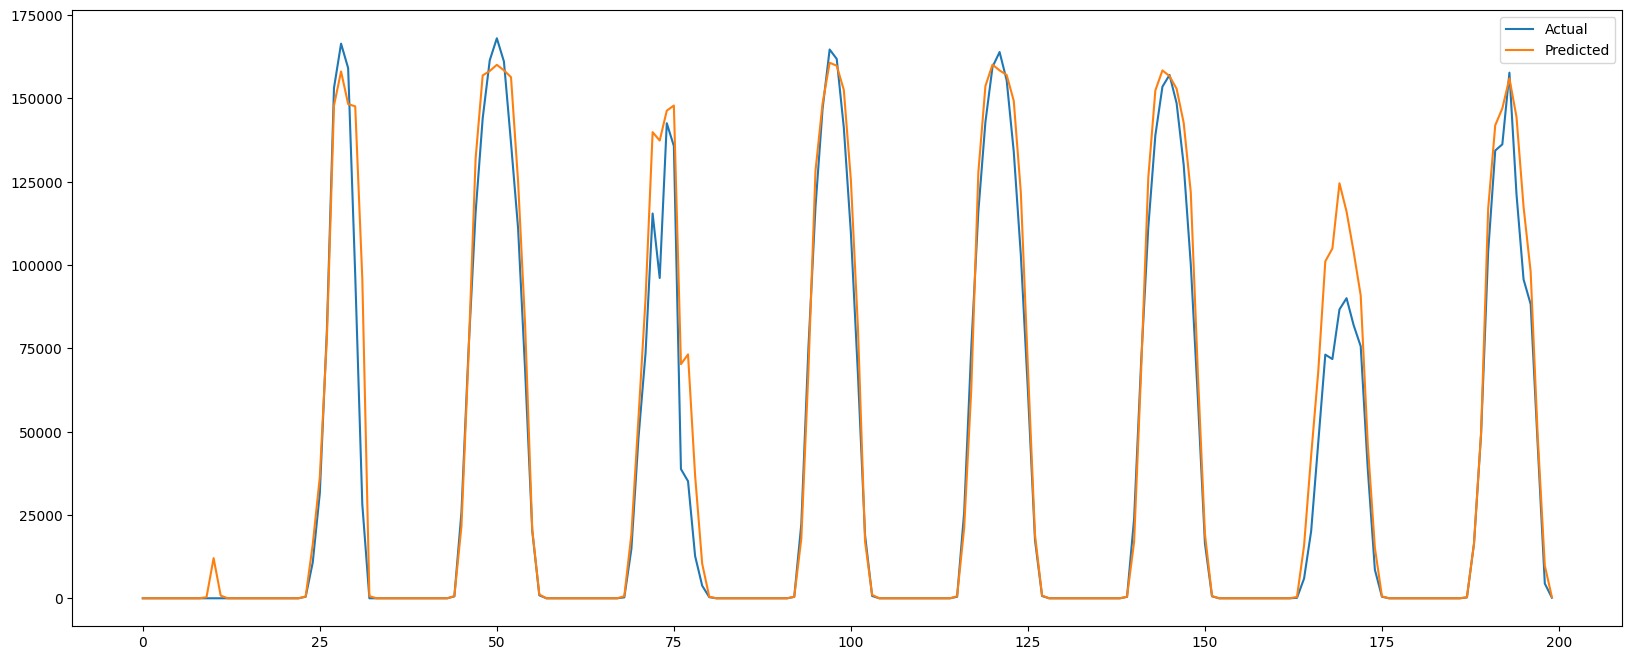

Best loss: 4976.03062925681


RandomForestRegressor(max_features=64, min_samples_leaf=4, min_samples_split=10,
                      n_estimators=40)

In [13]:
model_factory = lambda **params: RandomForestRegressor(**params)

space = {
    'n_estimators': hp.choice('n_estimators', [10, 20, 40]),
    'max_depth': hp.choice('max_depth', [None, 4, 8, 16, 32, 64, 128]),
    'min_samples_split': hp.choice('min_samples_split', [10, 20, 40]),
    'min_samples_leaf': hp.choice('min_samples_leaf', [2, 4, 8]),
    'max_features': hp.choice('max_features', [ 8, 16, 32, 64]),
}

experiment(model_factory, space, max_evals=20)

### Gradient Boost Machine

Gradient Boost Machines (GBMs) represent another ensemble learning technique, but unlike RFs, they construct a model in a stage-wise fashion.
By sequentially building an ensemble of weak learners (typically decision trees), GBMs iteratively improve upon the predictions from prior stages.

100%|██████████| 100/100 [01:17<00:00,  1.29trial/s, best loss: 4681.679839533321]


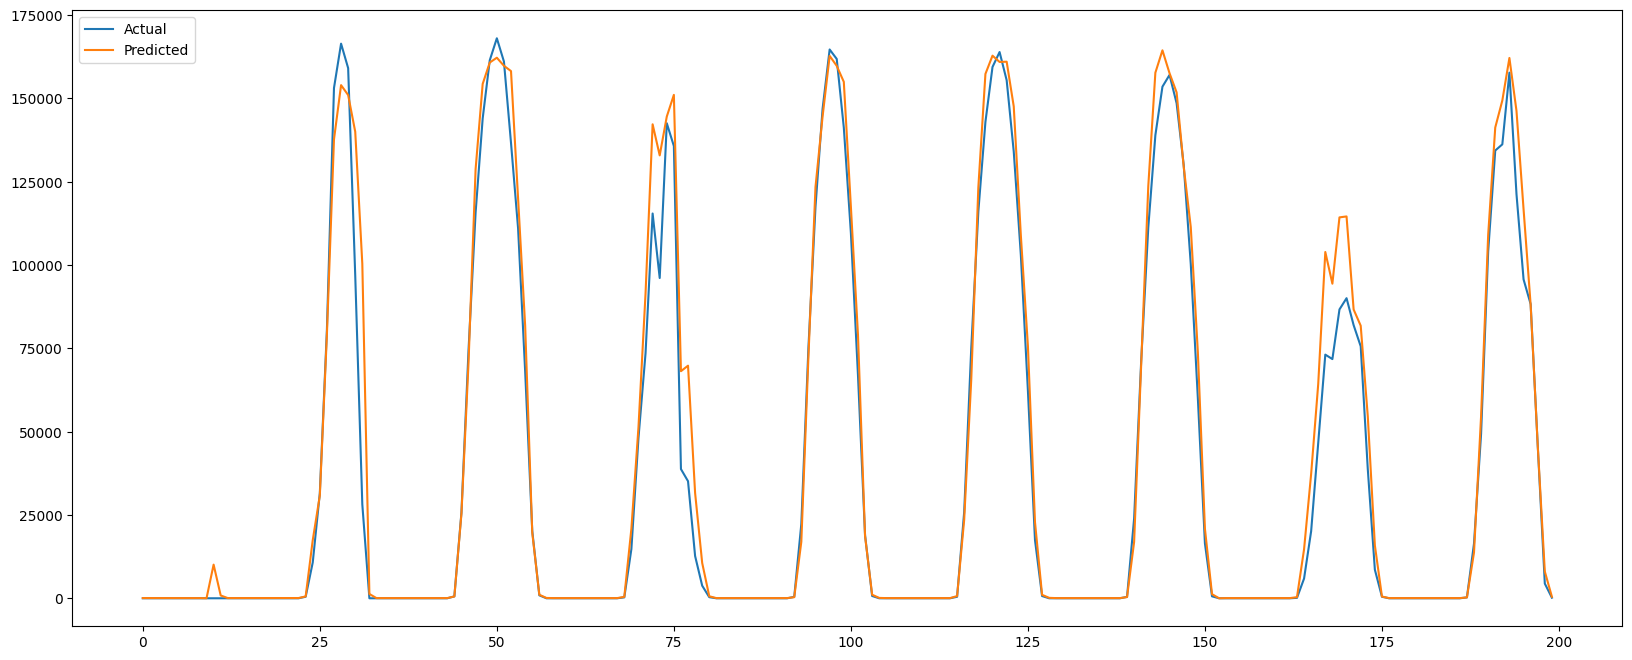

Best loss: 4681.679839533321


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.5675298390143003,
             colsample_bynode=0.542364644625781,
             colsample_bytree=0.8237715139338957, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1243578110765048, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=28, max_leaves=None,
             min_child_weight=6, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=-1,
             num_parallel_tree=None, random_state=None, ...)

In [14]:
model_factory = lambda **params: xgb.XGBRegressor(**params, n_jobs=-1)
space = {
    'n_estimators': hp.choice('n_estimators', [50]),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'max_depth': hp.uniformint('max_depth', 3, 64),
    'min_child_weight': hp.uniformint('min_child_weight', 1, 8),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.5, 1.0),
    'colsample_bynode': hp.uniform('colsample_bynode', 0.5, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
}

experiment(model_factory, space, max_evals=100)



## Neural Networks
Neural Networks (NNs) are powerful machine learning models inspired by the structure and function of the human brain. They consist of interconnected layers of artificial neurons that learn complex patterns from data through a process called backpropagation.
NNs' ability to capture non-linear relationships makes them suitable for modeling complex interactions between various factors that might influence power generation. Factors like weather patterns, historical generation data, and fuel availability can all be integrated into an NN for holistic prediction.
Additionally, NNs can potentially learn temporal patterns if the data includes time-series information. This could be beneficial for tasks like forecasting power demand or predicting peak generation periods.

100%|██████████| 200/200 [06:00<00:00,  1.80s/trial, best loss: 4362.404236520382]


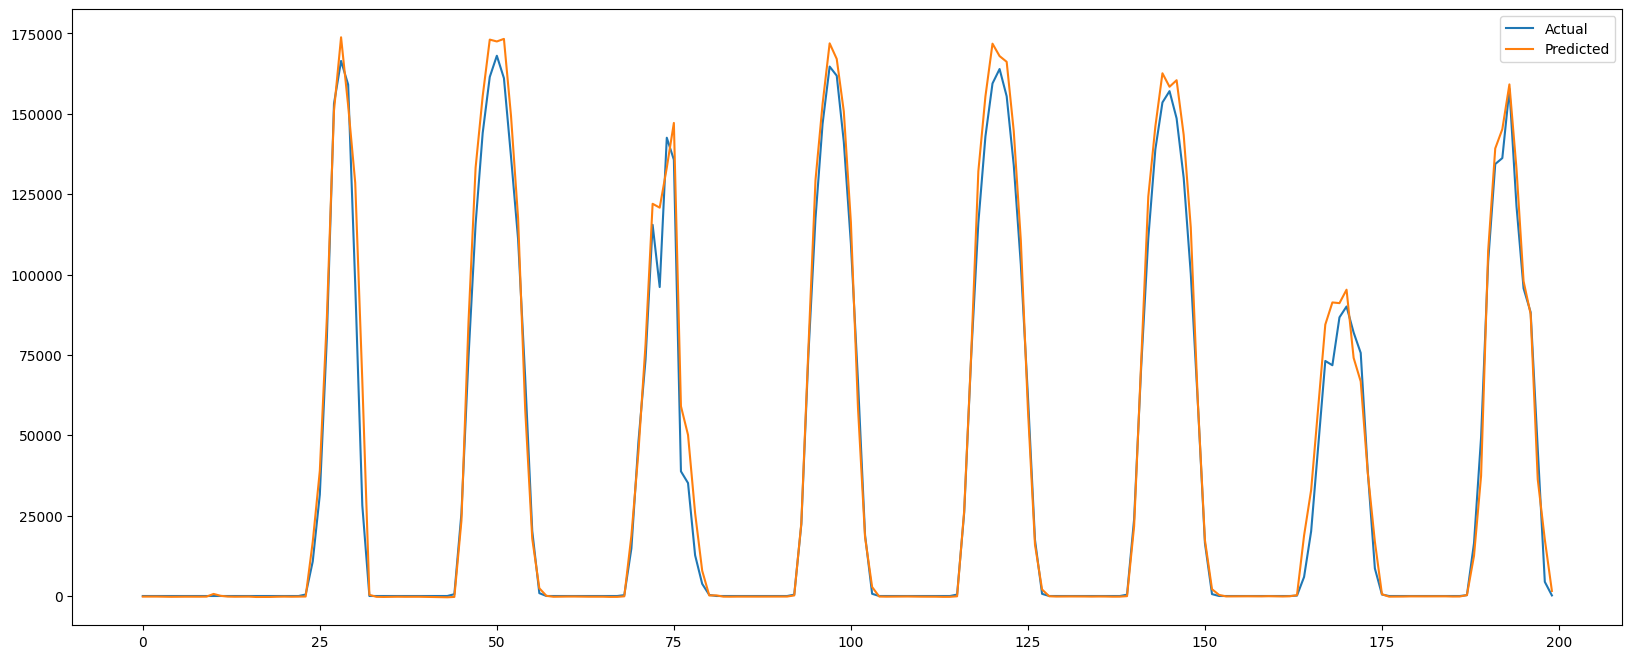

Best loss: 4362.404236520382


MLPRegressor(alpha=0.01610140824304669, batch_size=128, early_stopping=True,
             hidden_layer_sizes=(16, 16, 16), learning_rate='invscaling',
             learning_rate_init=0.028719159829316304, max_iter=100)

In [15]:
# MLPRegressor
from sklearn.neural_network import MLPRegressor
model_factory = lambda **params: MLPRegressor(**params)
space = {
    'hidden_layer_sizes': hp.choice('hidden_layer_sizes', [(16,), (16, 16), (16, 16, 16), (16, 16, 16, 16), (32,), (32, 32), (64,), (64, 64)]),
    'activation': hp.choice('activation', ['relu']),
    'solver': hp.choice('solver', ['adam']),
    'alpha': hp.uniform('alpha', 0.0001, 0.1),
    'batch_size': hp.choice('batch_size', [32, 64, 128]),
    'learning_rate': hp.choice('learning_rate', ['constant', 'invscaling', 'adaptive']),
    'learning_rate_init': hp.uniform('learning_rate_init', 0.0001, 0.1),
    'max_iter': hp.choice('max_iter', [100]),
    'early_stopping': hp.choice('early_stopping', [True]),
    'n_iter_no_change': hp.choice('n_iter_no_change', [10]),
}

experiment(model_factory, space, max_evals=200)

## LSTM

In the context of power generation prediction, data often exhibits temporal patterns. Historical generation data, weather forecasts with time-based information, and even energy consumption patterns can all be considered sequential. LSTMs are designed to effectively learn from and exploit such temporal dependencies within the data.

- Unlike some traditional forecasting methods, LSTMs can be readily adapted to predict power generation for various time horizons. This flexibility is valuable for power grid operators who need to plan for both short-term and long-term energy demands.
- LSTMs are generally more complex than standard NNs, requiring more data and computational resources for training. Evaluating the trade-off between complexity and potential gains in accuracy will be crucial.


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

n_steps = 8
n_features = x_train_scaled.shape[1]
x_train_lstm = np.array([x_train_scaled[i:i+n_steps, :] for i in range(len(x_train_scaled) - n_steps)])
y_train_lstm = y_train_scaled[n_steps:]

x_val_lstm = np.array([x_val_scaled[i:i+n_steps, :] for i in range(len(x_val_scaled) - n_steps)])
y_val_lstm = y_val_scaled[n_steps:]

model = Sequential([
    LSTM(32, activation='relu', input_shape=(n_steps, n_features)),
    Dense(16, activation='relu'),
    Dense(1, activation='linear')
])

model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

model.fit(x_train_lstm, y_train_lstm, validation_data=(x_val_lstm, y_val_lstm), batch_size=128, epochs=1000, callbacks=[early_stop])

losses = pd.DataFrame(model.history.history)
losses.plot()

plt.show()

y_pred = model.predict(x_val_lstm)
y_pred = y_scaler.inverse_transform(y_pred)

calculate_metrics(y_pred, y_val, 'LSTM', {})

# Results

,model,mae,mse,hyperparams
0,MLPRegressor,"4,362.40","62,790,397.12","{'activation': 'relu', 'alpha': 0.01610140824304669, 'batch_size': 128, 'early_stopping': True, 'hidden_layer_sizes': (16, 16, 16), 'learning_rate': 'invscaling', 'learning_rate_init': 0.028719159829316304, 'max_iter': 100, 'n_iter_no_change': 10, 'solver': 'adam'}"
0,MLPRegressor,"4,365.04","67,258,518.90","{'activation': 'relu', 'alpha': 0.029441708690870972, 'batch_size': 128, 'early_stopping': True, 'hidden_layer_sizes': (16, 16, 16), 'learning_rate': 'constant', 'learning_rate_init': 0.007352220319338649, 'max_iter': 100, 'n_iter_no_change': 10, 'solver': 'adam'}"
0,MLPRegressor,"4,425.43","64,027,726.98","{'activation': 'relu', 'alpha': 0.028492457563216205, 'batch_size': 128, 'early_stopping': True, 'hidden_layer_sizes': (16, 16, 16), 'learning_rate': 'constant', 'learning_rate_init': 0.011870855855802373, 'max_iter': 100, 'n_iter_no_change': 10, 'solver': 'adam'}"
0,MLPRegressor,"4,455.56","67,208,964.69","{'activation': 'relu', 'alpha': 0.03334504630747809, 'batch_size': 128, 'early_stopping': True, 'hidden_layer_sizes': (16, 16, 16), 'learning_rate': 'invscaling', 'learning_rate_init': 0.0020082950683365155, 'max_iter': 100, 'n_iter_no_change': 10, 'solver': 'adam'}"
0,MLPRegressor,"4,565.69","59,438,770.82","{'activation': 'relu', 'alpha': 0.04179408898232204, 'batch_size': 128, 'early_stopping': True, 'hidden_layer_sizes': (32, 32), 'learning_rate': 'constant', 'learning_rate_init': 0.005877124618629193, 'max_iter': 100, 'n_iter_no_change': 10, 'solver': 'adam'}"
0,MLPRegressor,"4,604.91","69,300,820.95","{'activation': 'relu', 'alpha': 0.027332640882940462, 'batch_size': 128, 'early_stopping': True, 'hidden_layer_sizes': (16, 16, 16), 'learning_rate': 'constant', 'learning_rate_init': 0.011100575668813693, 'max_iter': 100, 'n_iter_no_change': 10, 'solver': 'adam'}"
0,MLPRegressor,"4,608.20","64,106,912.52","{'activation': 'relu', 'alpha': 0.012439238388608708, 'batch_size': 128, 'early_stopping': True, 'hidden_layer_sizes': (16, 16, 16), 'learning_rate': 'constant', 'learning_rate_init': 0.023179453179833522, 'max_iter': 100, 'n_iter_no_change': 10, 'solver': 'adam'}"
0,MLPRegressor,"4,663.76","70,279,737.53","{'activation': 'relu', 'alpha': 0.032212579864551595, 'batch_size': 128, 'early_stopping': True, 'hidden_layer_sizes': (16, 16, 16), 'learning_rate': 'constant', 'learning_rate_init': 0.013691498325053876, 'max_iter': 100, 'n_iter_no_change': 10, 'solver': 'adam'}"
0,MLPRegressor,"4,663.95","68,926,422.84","{'activation': 'relu', 'alpha': 0.01694824260068001, 'batch_size': 128, 'early_stopping': True, 'hidden_layer_sizes': (16, 16, 16, 16), 'learning_rate': 'invscaling', 'learning_rate_init': 0.010363541162460629, 'max_iter': 100, 'n_iter_no_change': 10, 'solver': 'adam'}"
0,XGBRegressor,"4,681.68","87,972,234.45","{'colsample_bylevel': 0.5675298390143003, 'colsample_bynode': 0.542364644625781, 'colsample_bytree': 0.8237715139338957, 'learning_rate': 0.1243578110765048, 'max_depth': 28, 'min_child_weight': 6, 'n_estimators': 50, 'reg_alpha': 0.3517070465048244, 'reg_lambda': 0.6502607239178084, 'subsample': 0.9693116349415698}"


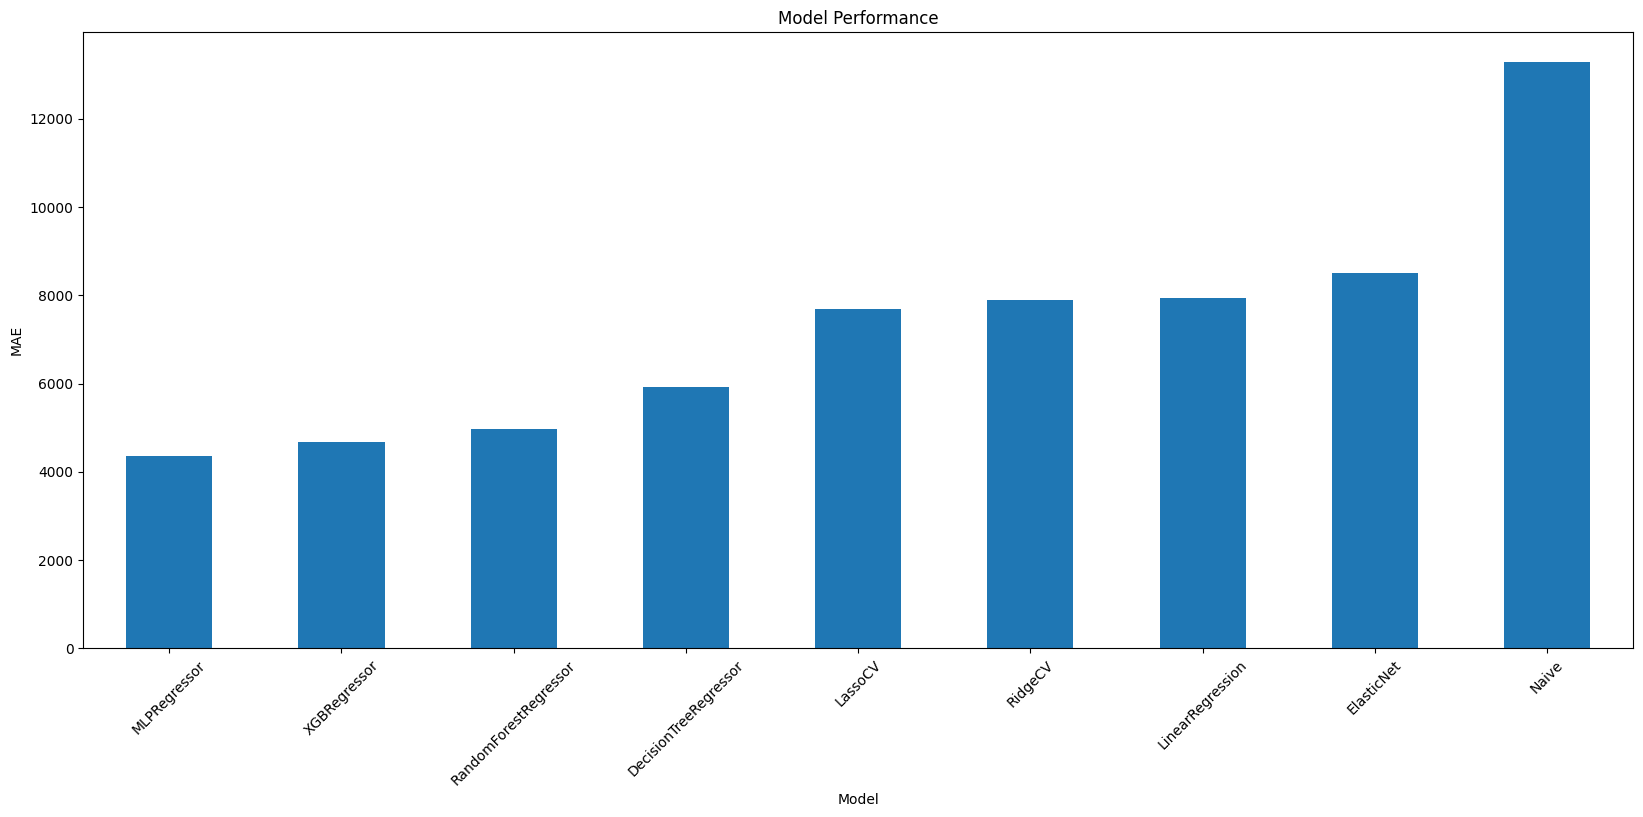

model
MLPRegressor                        4,362.40
XGBRegressor                        4,681.68
RandomForestRegressor               4,976.03
DecisionTreeRegressor               5,910.33
LassoCV                             7,680.12
RidgeCV                             7,901.13
LinearRegression                    7,929.63
ElasticNet                          8,506.92
Naive                              13,297.46
Name: mae, dtype: float64

In [28]:
display(results.sort_values('mae').head(20))
results_grouped = results.groupby('model').mae.min().sort_values()

plt.figure(figsize=(20, 8))
results_grouped.plot(kind='bar')

plt.title('Model Performance')
plt.ylabel('MAE')
plt.xlabel('Model')
plt.xticks(rotation=45)

plt.show()
display(results_grouped)

The evaluation process indicates that the Multi-Layer Perceptron (MLP) Neural Network architecture, currently achieves the best performance on the power generation prediction task. 

**Observations:**

The MLPRegressor outperforms previously explored methods, including XGBoost, with a Mean Absolute Error (MAE) of 4,362.40. Notably, all evaluated models achieved significantly lower MAE compared to the baseline "Naive" model (MAE of 13,297.46), demonstrating their effectiveness in predicting power generation.

**Potential Explanations:**

- Non-linearity Modeling: Power generation data might exhibit intricate non-linear dependencies between various features like weather patterns, historical generation, and fuel availability. MLPs excel at learning such non-linearities, potentially leading to superior performance compared to XGBoost, which might struggle with these complexities.
- Feature Representation: The chosen features and their preprocessing might be particularly suitable for MLP learning. 

# Model interpretation

## Linear Regression model coefficients
These coefficients quantify the magnitude and direction of the relationship between each independent variable and the dependent variable predicted by the model. By analyzing these coefficients, we can gain valuable insights into:

- Feature Importance: The relative impact of each feature on the predicted power generation. Larger coefficients (positive or negative) indicate a stronger influence on the prediction.
- Relationship Direction: The positive or negative sign of a coefficient reveals the direction of the relationship between the feature and the target variable. A positive coefficient suggests that increasing the feature value leads to an increase in predicted power generation, while a negative coefficient indicates the opposite trend.

Understanding these coefficient interpretations allows us to:

- Evaluate Model Explainability: Assess how well the model captures the relationships between the features and the target variable.
- Prioritize Features: Identify the most influential features for power generation prediction, potentially informing data collection or feature engineering efforts in future analyses.

season_1                                      3.83
Direct Shortwave Radiation                    2.82
season_2                                      1.28
Diffuse Shortwave Radiation                   1.14
hour_18                                      -0.69
hour_9                                       -0.69
hour_20                                      -0.69
hour_8                                       -0.69
hour_7                                       -0.69
hour_21                                      -0.69
hour_22                                      -0.69
hour_23                                      -0.69
hour_6                                       -0.69
hour_5                                       -0.69
hour_4                                       -0.69
hour_3                                       -0.69
hour_2                                       -0.69
hour_1                                       -0.69
hour_0                                       -0.69
month_2                        

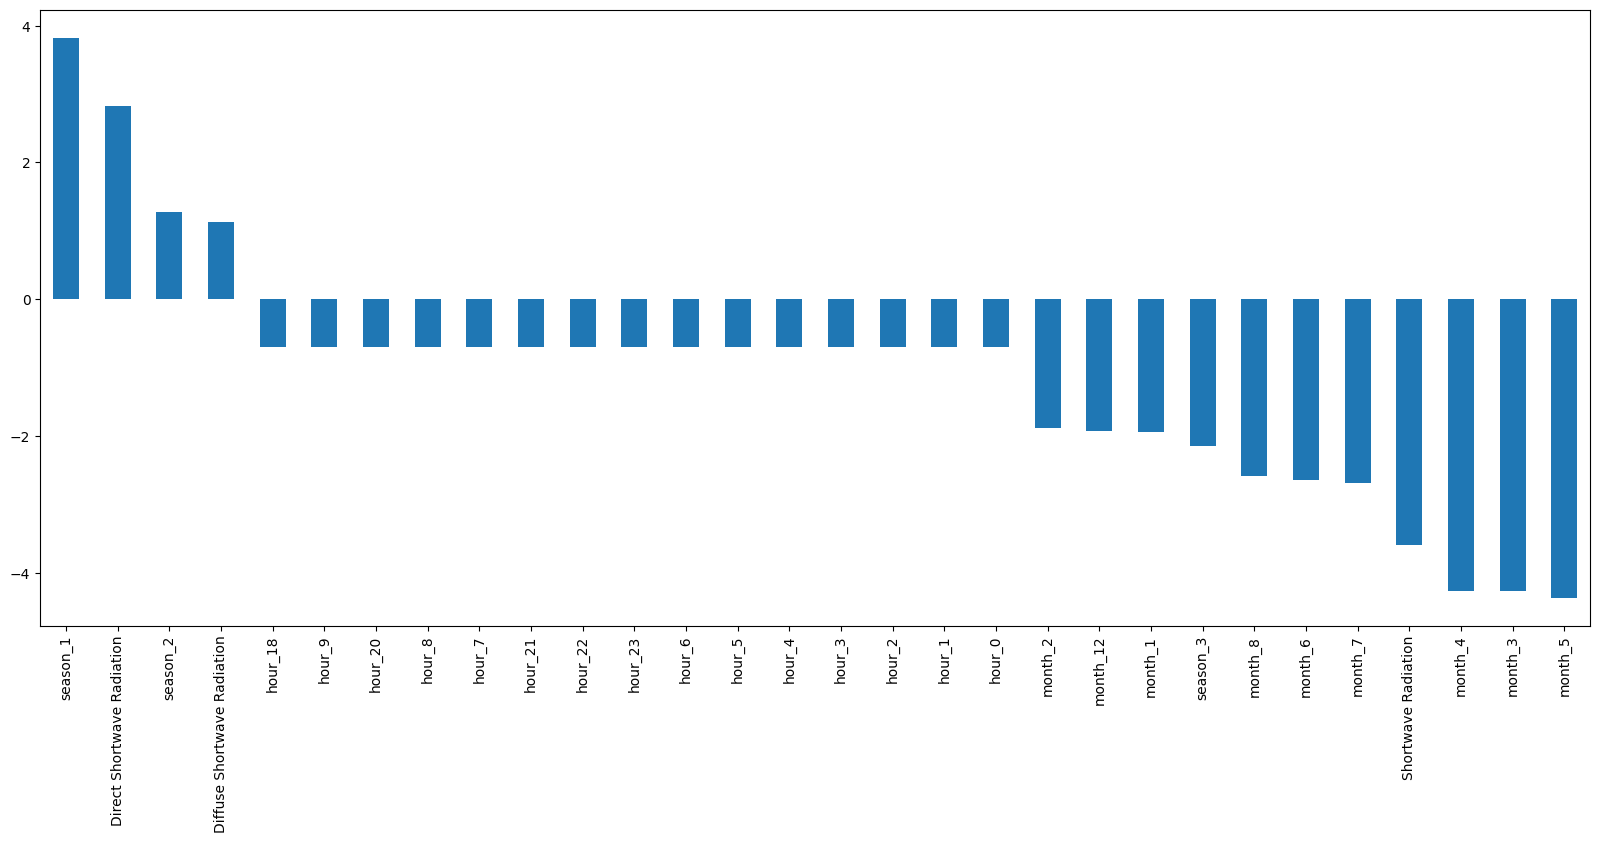

In [43]:

model = make_pipeline(StandardScaler(), LinearRegression(fit_intercept=True))
model.fit(x_train, y_train)
y_pred = model.predict(x_val)

coefs = model.named_steps['linearregression'].coef_
coefs = coefs / coefs.std()
coefs = pd.Series(coefs, index=x_train.columns)

# Keep only top 20 most influential features
coefs = coefs[np.argsort(np.abs(coefs))][-30:]
coefs = coefs.sort_values(ascending=False)

display(coefs)
plt.figure(figsize=(20, 8))
coefs.plot(kind='bar')
plt.show()


Unsurprisingly, most influencial features are radiation, season, month and hour of day.

In [44]:
model = make_pipeline(StandardScaler(), xgb.XGBRegressor(n_estimators=50, learning_rate=0.1, max_depth=8, min_child_weight=4, subsample=0.5, colsample_bytree=0.5, colsample_bylevel=0.5, colsample_bynode=0.5, reg_alpha=0.0, reg_lambda=0.0, n_jobs=-1))
model.fit(x_train, y_train)
y_pred = model.predict(x_val)

model.named_steps['xgbregressor'].get_booster().get_score(importance_type='gain')
importances = pd.Series(model.named_steps['xgbregressor'].feature_importances_, index=x_train.columns)

importances = importances[np.argsort(importances)]
importances = importances[-20:]
importances = importances.sort_values(ascending=False)

display(importances)

UV Radiation                                               0.25
Shortwave Radiation                                        0.14
Diffuse Shortwave Radiation                                0.09
DC Gen. Power 1 Hour Lag                                   0.08
Device Temp.                                               0.05
hour_18                                                    0.03
hour_19                                                    0.03
DC Gen. Power 720 Hour Lag                                 0.02
Direct Shortwave Radiation                                 0.02
hour_17                                                    0.02
Solar Zenith Angle                                         0.02
Temperature 24 Hour Rolling EMA                            0.01
DC Gen. Power 24 Hour Rolling Max                          0.01
hour_10                                                    0.01
DC Gen. Power 720 Hour Rolling EMA                         0.01
Temperature                             

In [45]:
# get the top 20 features from both models
top_features = list(set(importances.index) | set(coefs.index))

In [49]:
# train MLPRegressor with only the top features:
x_train_top = x_train[top_features]
x_val_top = x_val[top_features]

model = make_pipeline(StandardScaler(), MLPRegressor(hidden_layer_sizes=(16, 16, 16), activation='relu', solver='adam', alpha=0.02, batch_size=256, learning_rate='constant', learning_rate_init=0.08, max_iter=1000, early_stopping=True, n_iter_no_change=10))
model.fit(x_train, y_train)
y_pred = model.predict(x_val)

calculate_metrics(y_pred, y_val, 'MLPRegressor', {})

(92517171.66831617, 9618.584701935944, 5158.42729280696)